<a href="https://colab.research.google.com/github/lagom-QB/M12/blob/master/practice01_simple_text_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practice 01. Simple text processing.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython import display

### Toxic or not
Our main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

*Credits: This homework is inspired by YSDA NLP_course.*

In [2]:
# In colab uncomment this cell
! wget https://raw.githubusercontent.com/neychev/harbour_dlia2020/master/day01/utils.py -nc

File ‘utils.py’ already there; not retrieving.



In [3]:
try:
    data = pd.read_csv('../datasets/comments_small_dataset/comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/neychev/harbour_dlia2020/master/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

File ‘comments.tsv’ already there; not retrieving.



In [4]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [0]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [6]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [0]:
# task: preprocess each comment in train and test

texts_train = np.array(list(map(preprocess, texts_train))) #<YOUR CODE>
texts_test = np.array(list(map(preprocess, texts_test))) #<YOUR CODE> 

In [8]:
texts_train[5]

'who cares anymore . they attack with impunity .'

In [0]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [10]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))

bow_vocabulary = list(set(' '.join(texts_train).split()))                                    #<YOUR CODE>

n = 100
print(k,'\nexample features:', len(sorted(bow_vocabulary)[::n]))                             #Words that appear n times

5722 
example features: 58


In [0]:
word_to_index = {word:index for index,word in enumerate(bow_vocabulary)}

In [12]:
word_to_index.get('bag')

3331

In [13]:
VOCABULARY_SIZE = len(bow_vocabulary)
VOCABULARY_SIZE

5722

In [0]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    #<YOUR CODE>
    global VOCABULARY_SIZE, word_to_index
    bow_vector = np.zeros(VOCABULARY_SIZE, dtype=float)

    if isinstance(text, str) :
        text = text.split(' ')

    for word in text:
        word_index = word_to_index.get(word, -1)
        if word_index >= 0:
            bow_vector[word_index] += 1.

    return bow_vector

In [0]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [16]:
len(X_train_bow)

500

In [0]:
# Small check that everything is done properly
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Now let's do the trick with `sklearn` logistic regression implementation:

In [0]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)   #<YOUR CODE>

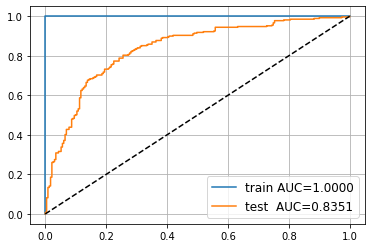

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Seems alright. Now let's create the simple logistic regression using PyTorch. Just like in the classwork.

In [0]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

In [0]:
from utils import plot_train_process

In [0]:
model = nn.Sequential(nn.Linear(VOCABULARY_SIZE, 2))                                                                   ### YOUR CODE HERE
model.add_module('dropout1', nn.Dropout2d(p = .73))

Remember what we discussed about loss functions! `nn.CrossEntropyLoss` combines both log-softmax and `NLLLoss`.

__Be careful with it! Criterion `nn.CrossEntropyLoss` with still work with log-softmax output, but it won't allow you to converge to the optimum.__ Next comes small demonstration:

In [0]:
# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()

In [0]:
opt = torch.optim.Adagrad(model.parameters())                                                                           ### YOUR CODE HERE

In [0]:
X_train_bow_torch = torch.tensor(X_train_bow, dtype=torch.float32)                                                      ### YOUR CODE HERE
X_test_bow_torch = torch.tensor(X_test_bow, dtype=torch.float32)                                                        ### YOUR CODE HERE

y_train_torch = torch.tensor(y_train, dtype=torch.long)                                                                 ### YOUR CODE HERE
y_test_torch = torch.tensor(y_test, dtype=torch.long)                                                                   ### YOUR CODE HERE

Let's test that everything is fine

In [0]:
# example loss
loss = loss_function(model(X_train_bow_torch[:3]), y_train_torch[:3])

In [0]:
assert type(loss.item()) == float

Here comes small function to train the model. In future we will take in into separate file, but for this homework it's ok to implement it here. 

In [0]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=256,
    warm_start=False,
    show_plots=True,
    eval_every=10
):
    if not warm_start:
        for name, module in model.named_children():
            print('resetting ', name)
            try:
                module.reset_parameters()
                print('reset ', name)
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        # ix = SelectKBest(score_func=f_classif, k = batch_size).fit(X_train_torch, y_train_torch).scores_    #### <<<<< ERROR HERE or smthx
        
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)                                                                                       ### YOUR CODE

        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch)                                                                          ### YOUR CODE

        # compute gradients
        loss.backward()                                                                                                     ### YOUR CODE

        # Adam step
        opt.step()                                                                                                          ### YOUR CODE

        # clear gradients
        opt.zero_grad()                                                                                                     ### YOUR CODE

        local_train_loss_history.append(loss.data.numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
        print("Misclassified %d out of total %d points"% ((y_val_torch != predictions_val).sum(),x_batch.shape[0]))
    return model

Let's run it on the data. Note, that here we use the `test` part of the data for validation. It's not so good idea in general, but in this task our main goal is practice.

In [0]:
lr_scheduler = ReduceLROnPlateau(opt, verbose=True, patience=5)

In [30]:
loss

tensor(0.6931, grad_fn=<NllLossBackward>)

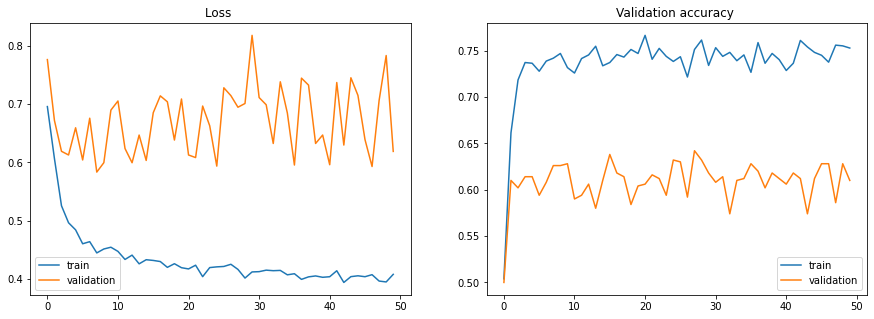

Sequential(
  (0): Linear(in_features=5722, out_features=2, bias=True)
  (dropout1): Dropout2d(p=0.73, inplace=False)
)

In [31]:
from sklearn.feature_selection import SelectKBest,f_classif

train_model(model, 
            opt, 
            lr_scheduler, 
            X_train_bow_torch, 
            y_train_torch, 
            X_test_bow_torch, 
            y_test_torch)

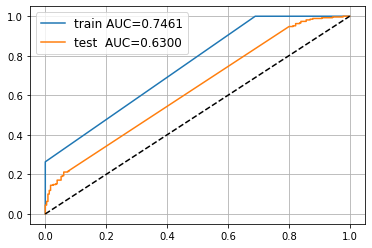

In [32]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow_torch, y_train, model),
    ('test ', X_test_bow_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

In [33]:
X_train_bow_torch.shape

torch.Size([500, 5722])

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

In [0]:
from sklearn.feature_selection import SelectKBest,f_classif

n = [10,
     50,
     100,
     500]


model_ass = nn.Sequential(nn.Linear(VOCABULARY_SIZE, 2), 
                          nn.Dropout2d(p = .52))   
optimizer_ass = torch.optim.AdamW(model_ass.parameters(), lr = 0.001)
lr_scheduler_ass = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ass, patience=5)

def work(token_list):
  TOKEN_COUNT =  len(token_list)

  print(train_model(model_ass, 
          optimizer_ass, 
          lr_scheduler_ass, 
          X_train_bow_torch, 
          y_train_torch, 
          X_test_bow_torch, 
          y_test_torch,
          batch_size = TOKEN_COUNT))
  
  for name, X, y, model in [
    ('train', X_train_bow_torch, y_train, model_ass),
    ('test ', X_test_bow_torch, y_test, model_ass)
    ]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.grid()
  
tokens = []
for i in n:
    tokens.append(sorted(bow_vocabulary)[:i])

In [35]:
print([(len(i)) for i in tokens])

[10, 50, 100, 500]


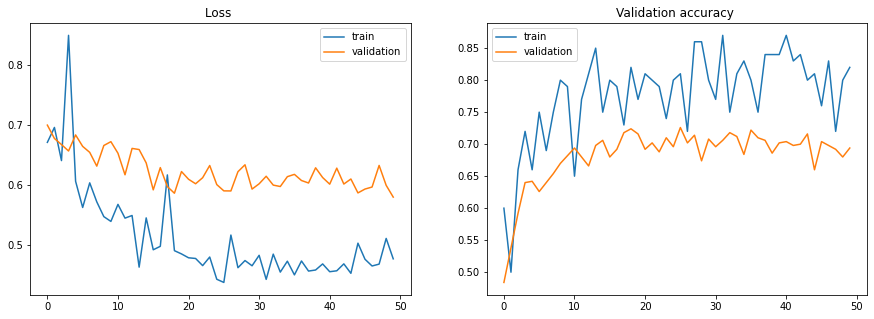

Sequential(
  (0): Linear(in_features=5722, out_features=2, bias=True)
  (1): Dropout2d(p=0.52, inplace=False)
)


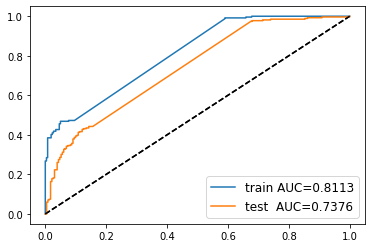

In [36]:
work(tokens[0])

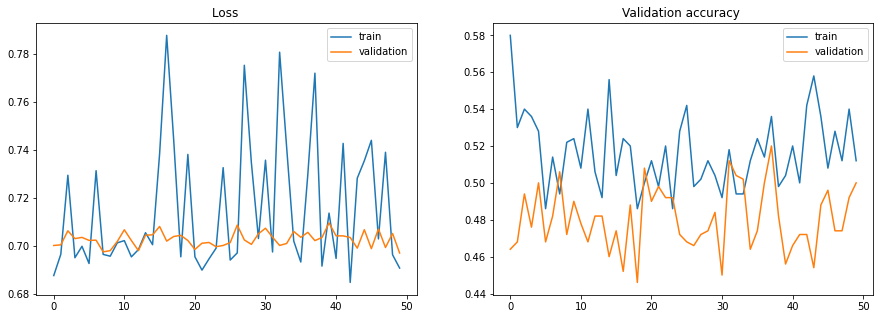

Sequential(
  (0): Linear(in_features=5722, out_features=2, bias=True)
  (1): Dropout2d(p=0.52, inplace=False)
)


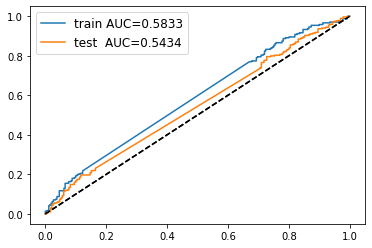

In [37]:
work(tokens[1])

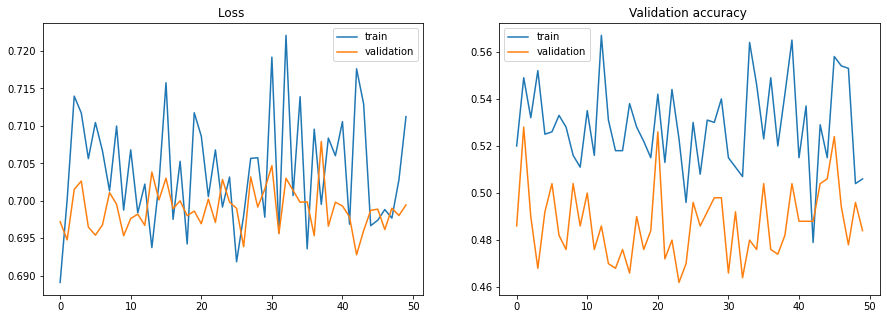

Sequential(
  (0): Linear(in_features=5722, out_features=2, bias=True)
  (1): Dropout2d(p=0.52, inplace=False)
)


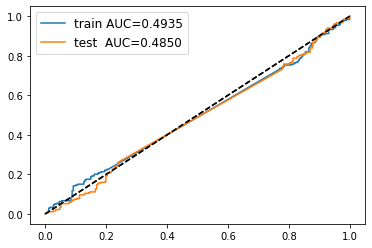

In [38]:
work(tokens[2])

>*There is some witchery going on here*
>> But the accuracy should decrease with fewer items selected so ... but still

### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [0]:
# Just reinitializing because if not then why not

texts_train_, texts_test_, y_train_, y_test_ = train_test_split(texts, target, test_size=0.5, random_state=42)

texts_test_ = list(map(preprocess, texts_test_))
texts_train_ = list(map(preprocess, texts_train_))


In [0]:
texts_test_data = [sentence.split(' ') for sentence in texts_test_]
texts_train_data = [sentence.split(' ') for sentence in texts_train_]

In [0]:
# texts_test_data[0], texts_train_data[0]

In [0]:
# Compute tf map
def computeTFDict(text):
    """computes the TF score for each word in the corpus, by document
    """
    TFDict = {}
    for word in text:
        if word in TFDict:
            TFDict[word] += 1
        else:
            TFDict[word] = 1
    # Computes tf for each word
    for word in TFDict:
        TFDict[word] = TFDict[word] / len(text)
    return TFDict

test_tfDict = [computeTFDict(texts_test_datum) for texts_test_datum in texts_test_data]
train_tfDict = [computeTFDict(texts_train_datum) for texts_train_datum in texts_train_data]

# Count the occurance of words in the dictionary
def computeCount(TFDict):
    count = {}
    for text in TFDict:
        for word in text:
            if word in count:
                count[word] += 1
            else:
                count[word] = 1
    return count

test_wordCount = computeCount(test_tfDict)
train_wordCount = computeCount(train_tfDict)

# Compute idf
def computeIDFDict(text_data, wordCount):
    # Computes the IDF score of every word in the corpus.
    IDFDict = {}
    for word in wordCount:
        IDFDict[word] = np.log(len(text_data)/ wordCount[word])
    return IDFDict

test_idfDict = computeIDFDict(texts_test_data, test_wordCount)
train_idfDict = computeIDFDict(texts_train_data, train_wordCount)

# TF-IDF(term) = TF(term) * IDF(term)
def computeTFIDFDict(TFDict, IDFDict):
    TFIDFDict = {}
    #For each word , we multiply its tf and its idf.
    for word in TFDict:
        TFIDFDict[word] = TFDict[word] * IDFDict[word]
    return TFIDFDict

test_tfidfDict = [computeTFIDFDict(test_tfDict_item, test_idfDict) for test_tfDict_item in test_tfDict]
train_tfidfDict = [computeTFIDFDict(train_tfDict_item, train_idfDict) for train_tfDict_item in train_tfDict]

# Build a matrix, each representing a tf of each word in the text
def computeTFIDFVector(text, text_wordCount):
    TFIDFVector = [0.0] * len(text_wordCount)

    for idx, word in enumerate(text_wordCount):
        if word in text:
            TFIDFVector[idx] = text[word]
    return TFIDFVector

test_words = sorted(test_wordCount.keys())
train_words = sorted(train_wordCount.keys())
test_tfidfVector = [computeTFIDFVector(test_tfidfDict_item, test_words) for test_tfidfDict_item in test_tfidfDict]
train_tfidfVector = [computeTFIDFVector(test_tfidfDict_item, test_words) for test_tfidfDict_item in test_tfidfDict]

Same stuff about model and optimizers here (or just omit it, if you are using the same model as before).

In [0]:
X_train_tfidf_torch = torch.tensor(train_tfidfVector, dtype=torch.float32)                  ### YOUR CODE HERE
X_test_tfidf_torch = torch.tensor(test_tfidfVector, dtype=torch.float32)                    ### YOUR CODE HERE

y_train_torch_ = torch.tensor(y_train_, dtype=torch.long)                                     ### YOUR CODE HERE
y_test_torch_ = torch.tensor(y_test_, dtype=torch.long)                                       ### YOUR CODE HERE

In [44]:
X_train_bow_torch.shape, X_train_tfidf_torch.shape, 

(torch.Size([500, 5722]), torch.Size([500, 4946]))

In [45]:
ASS_1_SIZE = X_train_tfidf_torch.shape[1] #<< Let's agree to disagree
ASS_1_SIZE

4946

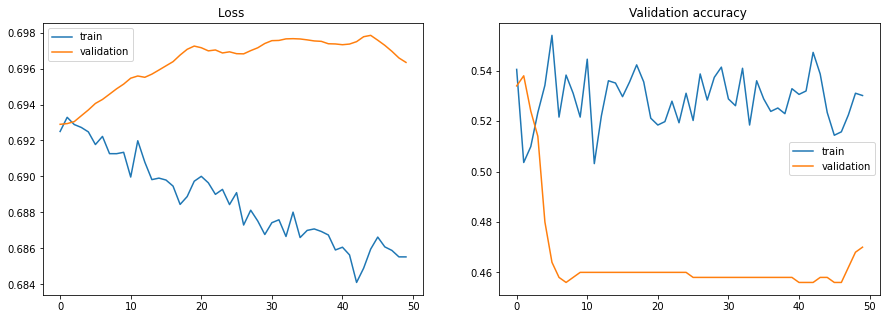

Linear(in_features=4946, out_features=2, bias=True)

In [115]:
model_ass_1 = nn.Linear(ASS_1_SIZE, 2)
optimizer_ass_1 = torch.optim.SGD(model_ass_1.parameters(), lr = 0.002, momentum=0.9)
lr_scheduler_ass_1 = ReduceLROnPlateau(optimizer_ass_1)

train_model(model_ass_1, 
        optimizer_ass_1, 
        lr_scheduler_ass_1, 
        X_train_tfidf_torch, 
        y_train_torch_, 
        X_test_tfidf_torch, 
        y_test_torch_,
        batch_size = 222)

> When i put a test-size less than 0.5 this doesn't work. Dunno why though. *This happens when i experimented with Kselect maybe it has something to do with that. But it was just experimenting and i probably made an error in invoking so mehhh*

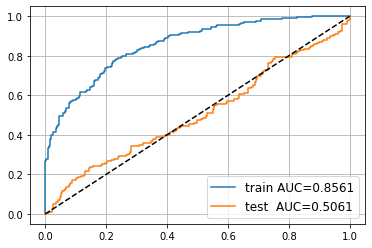

In [116]:
for name, X, y, model in [
    ('train', X_train_tfidf_torch, y_train_, model_ass_1),
    ('test ', X_test_tfidf_torch, y_test_, model_ass_1)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

>> I tried almost all optimizers and ended on SGD because it looks like i can improve it. And the graph looks more realistic *IMHO*

Fit your model to the data. No not hesitate to vary number of iterations, learning rate and so on.

_Note: due to very small dataset, increasing the complexity of the network might not be the best idea._

### Step 3: Comparing it with Naive Bayes

Naive Bayes classifier is a good choice for such small problems. Try to tune it for both BOW and TF-iDF features. Compare the results with Logistic Regression.

In [130]:
from sklearn.naive_bayes import GaussianNB

naive_baye_model = GaussianNB()
prediction = torch.tensor(naive_baye_model.fit(X_train_tfidf_torch, y_train_torch_).predict(X_test_tfidf_torch), dtype=torch.long)
print("Misclassified %d out of total %d points"% ((y_test_torch_ != prediction).sum(),X_test_tfidf_torch.shape[0]))

Misclassified 248 out of total 500 points


In [138]:
prediction_1 = torch.tensor(model_ass_1(X_train_tfidf_torch), dtype=torch.long)
print("Misclassified %d out of total %d points"% ((y_test_torch_ != prediction_1).sum(),X_test_tfidf_torch.shape[0]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


RuntimeError: ignored

Shape some thoughts on the results you aquired. Which model has show the best performance? Did changing the learning rate/lr scheduler help?

_Your beautiful thoughts here_

### Step 4: Using the external knowledge.

Use the `gensim` word2vec pretrained model to translate words into vectors. Use several models with this new encoding technique. Compare the results, share your thoughts.

In [0]:
# Your beautiful code here

### Step 5: Visualizing the embeddings

Finally, let's visualize the embeddings for every comment. One can use just averaged vector or use some more complex models. We recommend using `umap` (`pip install umap-learn`) to map everything to 2-dimensional space. For inspiration one might refer to the [day 14](https://github.com/neychev/harbour_ml2020/tree/master/day14_Unsupervised_learning) practice of the Machine Learning course.

In [0]:
# Your beautiful code here